### Imports and config

In [1]:
# Libraries
import os
from importlib import reload
import keras

# Scripts
from helpers import data, runners, utils

In [2]:
# Should be v2.10
!pip show tensorflow 

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
# Should be v2.10
!pip show keras 

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(data)
reload(runners)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [6]:
NUM_FOLDS = 10
NUM_EPOCHS = 5
GPU_BATCH_SIZE = 16
DATA_BATCH_SIZE = 16

### Load data

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv='../data/DATASET_CSVS/deepship_5k_seg_3s.csv',
    new_path_to_root='../data/deepship_baseline_channel_normalised',
    ext='mat',
    unix=False,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)
print('Successfully loaded folds.\n')

Successfully loaded folds.



In [8]:
total_samples = 0
for fold_df in fold_dfs:
    total_samples += len(fold_df)
print(total_samples)

53502


### Initialise and configure model

In [9]:
def get_compiled_model():
    """
    The caller should write this function to return a compiled
    `keras.Model` object to be fed into the k-fold cross validation script.
    """

    from models import cnn_lstm

    cnn_lstm_model = cnn_lstm.get_cnn_lstm(
        input_shape=(192, 192, 1),
        input_name='spec',
        num_classes=4,
        verbose=False
    )

    cnn_lstm_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['acc']
    )

    return cnn_lstm_model

In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': NUM_EPOCHS,
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

eval_kwargs = {
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

### Run k-fold cross val

In [11]:
reload(runners)

# [DBS = GBS = 8] 5 folds, 3 epochs = 100 - 160 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 80 - 100 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 340 min
# [DBS = GBS = 16] 10 folds, 3 epochs = 450 - 500 min

model, histories, evals, metrics = runners.k_fold_cross_validation(
    fold_dfs=fold_dfs,
    model_builder=get_compiled_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    ext="mat",
    mat_var_name="channelNormalised",
    data_batch_size=DATA_BATCH_SIZE,
    use_cpu=False
)

FOLD 1/10
Epoch 1/5
2716/2716 [==============================] - 633s 230ms/step - loss: 0.7769 - acc: 0.6874 - val_loss: 0.7268 - val_acc: 0.7125
Epoch 2/5
2716/2716 [==============================] - 854s 315ms/step - loss: 0.4727 - acc: 0.8258 - val_loss: 0.8071 - val_acc: 0.6726
Epoch 3/5
2716/2716 [==============================] - 1026s 378ms/step - loss: 0.3142 - acc: 0.8935 - val_loss: 0.8180 - val_acc: 0.6793
Epoch 4/5
2716/2716 [==============================] - 1044s 384ms/step - loss: 0.2085 - acc: 0.9367 - val_loss: 0.9575 - val_acc: 0.6722
Epoch 5/5
1/1 [==============================] - 0s 19ms/step
FOLD 2/10
Epoch 1/5
2666/2666 [==============================] - 1015s 380ms/step - loss: 0.7802 - acc: 0.6838 - val_loss: 0.8885 - val_acc: 0.6727
Epoch 2/5
2666/2666 [==============================] - 1028s 386ms/step - loss: 0.4813 - acc: 0.8209 - val_loss: 0.9760 - val_acc: 0.6706
Epoch 3/5
2666/2666 [==============================] - 835s 313ms/step - loss: 0.3239 - acc:

In [12]:
model.save('models/saved/cnn_lstm_channel_normalised.keras')

### Calculate metrics

In [13]:
evals

[[0.9813248515129089, 0.6751325130462646],
 [0.8826091885566711, 0.6754737496376038],
 [1.1437221765518188, 0.6505255103111267],
 [1.3904966115951538, 0.5761151313781738],
 [1.2857768535614014, 0.622245192527771],
 [1.2605539560317993, 0.6043956279754639],
 [1.525352954864502, 0.5621044039726257],
 [1.1004754304885864, 0.6412500143051147],
 [1.3939131498336792, 0.5776848793029785],
 [0.7925043702125549, 0.731249988079071]]

In [14]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 1.1756729543209077
Average accuracy: 0.6316177010536194


C:\Users\sonar\AppData\Local\Temp\ipykernel_16944\2181760734.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


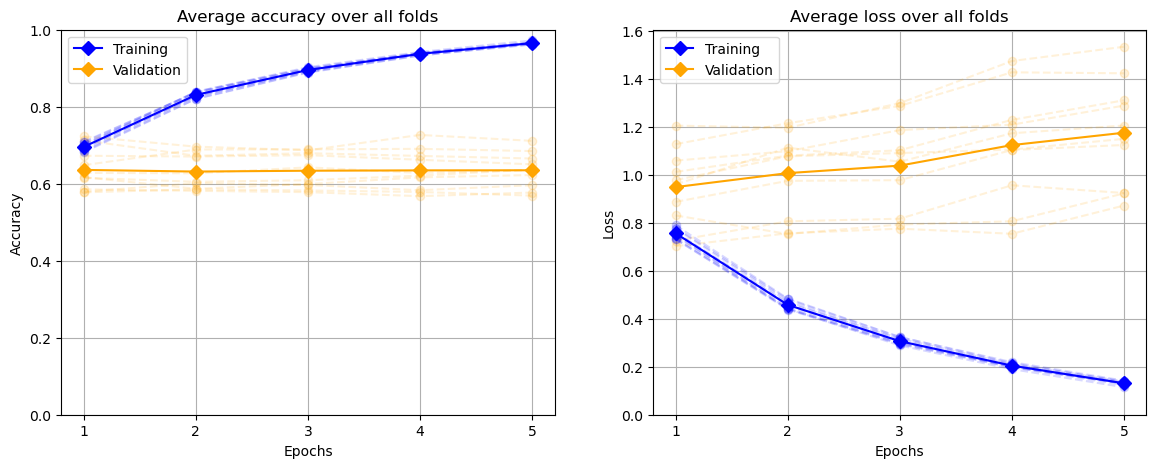

In [15]:
reload(utils)

fig = utils.get_acc_loss_curves_by_epoch(histories, overlay=True)
fig.savefig('models/saved/ampls_detrended_channel_normalised_by_epoch.pdf')
fig.show()

C:\Users\sonar\AppData\Local\Temp\ipykernel_16944\3693293723.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


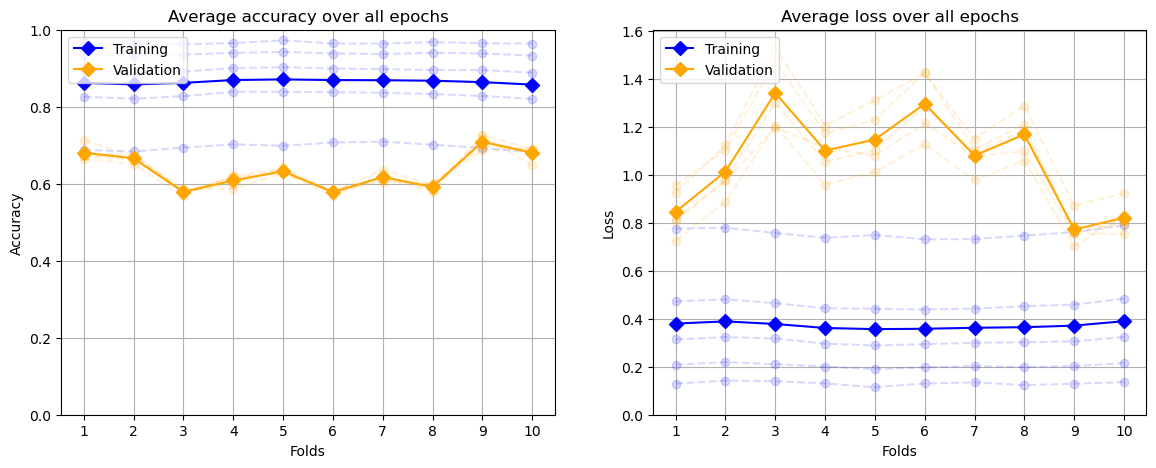

In [16]:
reload(utils)

fig = utils.get_acc_loss_curves_by_fold(histories, overlay=True)
fig.savefig('models/saved/ampls_detrended_channel_normalised_by_fold.pdf')
fig.show()

In [17]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])
print("Average Accuracy:", metrics["accuracy"])

Average Precision: 0.6634483006204724
Average Recall: 0.631617701351425
Average F1 Score: 0.6324200095570205
Average Accuracy: 0.631617701351425
